In [1]:
import os
import numpy as np
import pandas as pd


from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import librosa
import pydub

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint

C:\Users\Fifonsi Donald\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [18]:
import seaborn as sb


In [ ]:
audio_folder = "Genre_audios" 
feature_data = [] 
filenames = [] 
for root, dirs, files in os.walk(audio_folder): 
    for file in files: 
        if file.endswith(".wav"): 
            file_path = os.path.join(root, file) 
            audio, sr = librosa.load(file_path)

        stft = librosa.stft(audio)
        
        chroma_stft_mean = librosa.feature.chroma_stft(y = audio, sr=sr).mean()
        chroma_stft_var = librosa.feature.chroma_stft(y = audio, sr=sr).var()
        
        rms = librosa.feature.rms(y=audio)
        rms_mean = rms.mean()
        rms_var = rms.var()
        
        spectral_centroid_mean = librosa.feature.spectral_centroid(y=audio, sr=sr).mean()
        spectral_centroid_var = librosa.feature.spectral_centroid(y=audio, sr=sr).var()
        
        spectral_bandwidth_mean = librosa.feature.spectral_bandwidth(y=audio, sr=sr).mean()
        spectral_bandwidth_var = librosa.feature.spectral_bandwidth(y=audio, sr=sr).var()
        
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
        mfcc_vars = np.var(mfccs, axis=1)
        mfcc_means = np.mean(mfccs[1:], axis=1)
        
        
        
        label = os.path.basename(root)
        
        
        feature_data.append([file, len(audio), chroma_stft_mean, chroma_stft_var, rms_mean, rms_var,
                              spectral_centroid_mean, spectral_centroid_var, spectral_bandwidth_mean,
                              spectral_bandwidth_var] + mfcc_vars.tolist() + mfcc_means.tolist() + [label])

In [30]:
columns = ["filename", "length", "chroma_stft_mean", "chroma_stft_var", "rms_mean", "rms_var", 
           "spectral_centroid_mean", "spectral_centroid_var", "spectral_bandwidth_mean", "spectral_bandwidth_var"] + [f"mfcc{idx}_var" for idx in range(1, 21)] + \
           [f"mfcc{idx}_mean" for idx in range(1, 20)] + ["label"] 
df = pd.DataFrame(feature_data, columns=columns) 
df.to_csv("audio_features_dataset.csv", index=False) 
print("Feature extraction and dataset creation complete.")

Feature extraction and dataset creation complete.


In [31]:
df.head(5)

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc11_mean,mfcc12_mean,mfcc13_mean,mfcc14_mean,mfcc15_mean,mfcc16_mean,mfcc17_mean,mfcc18_mean,mfcc19_mean,label
0,Acid Jazz.00000.wav,655740,0.402352,0.085513,0.202610,0.004843,1896.774693,4.093286e+05,2331.513855,226944.202471,...,-0.192849,-0.085849,4.868845,1.264561,2.894667,0.940186,3.597382,1.816691,1.122448,Acid Jazz
1,Acid Jazz.00001.wav,655740,0.442952,0.093444,0.245184,0.008211,2427.520976,8.366833e+05,2758.329687,251983.775284,...,3.266522,-0.399626,-2.203053,5.074784,0.417766,-3.522619,3.052121,-1.211118,1.741534,Acid Jazz
2,Acid Jazz.00002.wav,655740,0.416966,0.090136,0.285146,0.008650,2634.559620,7.671155e+05,2769.010465,151081.368511,...,0.578705,-3.594477,4.030111,-3.881388,-0.969255,-4.642273,1.332455,-0.944916,-0.291937,Acid Jazz
3,Acid Jazz.00003.wav,655740,0.353967,0.096360,0.206427,0.002988,2904.060523,2.960671e+05,3054.098621,90685.163597,...,2.377535,0.615208,5.889778,0.836968,3.473822,2.340698,-2.560615,-3.358222,2.612275,Acid Jazz
4,Acid Jazz.00004.wav,655740,0.384187,0.098099,0.200074,0.011194,2143.054464,1.225630e+06,2573.305987,372125.614840,...,2.553064,-3.104615,2.341380,-4.060392,2.986679,-4.813811,1.864366,-4.529317,0.024426,Acid Jazz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,Zydeco.00002.wav,1323000,0.391823,0.079321,0.085058,0.000927,2049.316544,2.201990e+05,1938.630087,129681.353119,...,0.235334,-5.073430,-1.309265,-4.708318,0.008119,-2.668050,-0.958681,-5.808221,-3.452235,Zydeco
682,Zydeco.00003.wav,661848,0.318664,0.086652,0.106231,0.001698,2041.765096,2.179314e+05,1650.288276,25962.026686,...,-0.005288,-1.785722,1.758159,0.592610,-2.576060,-3.854228,2.069824,-4.499291,-2.557656,Zydeco
683,Zydeco.00004.wav,661500,0.432302,0.078625,0.150667,0.001463,3032.884169,1.937384e+05,2797.708405,34008.144761,...,0.861528,-5.060615,-0.781569,-5.080698,-0.490467,-7.695112,1.576223,-3.142891,-5.101171,Zydeco
684,Zydeco.00005.wav,1323000,0.393335,0.085445,0.263611,0.011489,2621.187365,4.424771e+05,2732.847935,73812.013335,...,-1.157288,-3.289649,-0.940517,-2.344251,2.942225,-1.794569,-0.939168,-7.341328,0.354832,Zydeco


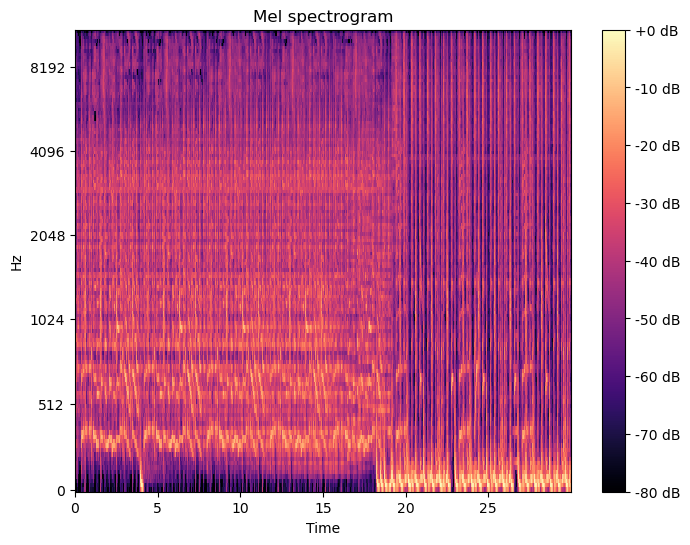

In [3]:
y, sr = librosa.load("Genre_audios/House/House.00002.wav")

plt.figure(figsize=(8, 6))
librosa.display.specshow(librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr), ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.show()

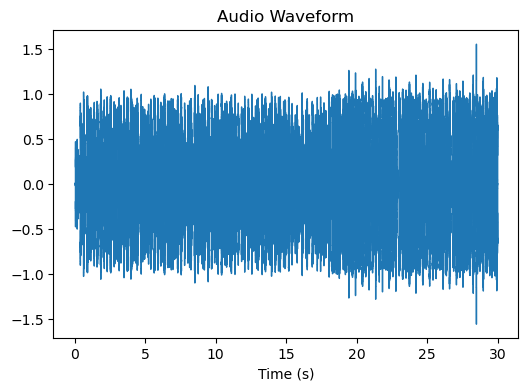

In [97]:
y, sr = librosa.load("Genre_audios/House/House.00002.wav")

# Plot the audio waveform
plt.figure(figsize=(6, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Audio Waveform')
plt.xlabel('Time (s)')
plt.show()

In [19]:
def features_extract(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled= np.mean(mfccs_features.T,axis = 0)
    
    return mfccs_scaled

In [23]:
df = pd.read_csv("audio_features_dataset.csv")
extracted_features = []
for index_num, row in tqdm(df.iterrows()):
    try:
        class_labels =row["label"]
        file_name = os.path.join(os.path.abspath("Genre_audios"), class_labels+'/',str(row["filename"]))
        data = features_extract(file_name)
        extracted_features.append([data, class_labels])
    except Exception as e:
        print(f"Error while processing {file_name}: {e}")
        continue

20it [01:24,  4.28s/it]C:\Users\Fifonsi Donald\AppData\Local\Temp\ipykernel_15972\2603887287.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
C:\Users\Fifonsi Donald\anaconda3\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Alternative Rock/Alternative Rock_counter.txt: 


26it [02:04,  7.40s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Ambient/Ambient_counter.txt: 


32it [02:34,  5.97s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Americana/Americana_counter.txt: 


38it [02:55,  4.14s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Art Pop/Art Pop_counter.txt: 


44it [03:28,  5.75s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Avant-Garde/Avant-Garde_counter.txt: 


50it [03:52,  4.59s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Baroque(classical)/Baroque(classical)_counter.txt: 


56it [04:15,  4.17s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Bebop/Bebop_counter.txt: 


62it [04:35,  3.74s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Bedroom Pop/Bedroom Pop_counter.txt: 


68it [05:09,  5.72s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Big Room/Big Room_counter.txt: 


74it [05:27,  3.70s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Black Metal/Black Metal_counter.txt: 


80it [05:46,  3.77s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Bluegrass/Bluegrass_counter.txt: 


91it [06:28,  3.76s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Boom Bap/Boom Bap_counter.txt: 


97it [06:45,  3.22s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Breakbeat/Breakbeat_counter.txt: 


103it [07:06,  3.73s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Bubblegum Pop/Bubblegum Pop_counter.txt: 


109it [07:37,  6.02s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Cello Rock/Cello Rock_counter.txt: 


115it [08:15,  5.94s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Celtic/Celtic_counter.txt: 


121it [08:36,  4.03s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Chicago Blues/Chicago Blues_counter.txt: 


127it [08:56,  3.78s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Christian Rock/Christian Rock_counter.txt: 


133it [09:16,  3.56s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Classic Rock/Classic Rock_counter.txt: 


139it [09:36,  3.63s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Conscious Rap/Conscious Rap_counter.txt: 


145it [09:55,  3.52s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Contemporary Gospel/Contemporary Gospel_counter.txt: 


151it [10:17,  3.91s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Contemporary R&B/Contemporary R&B_counter.txt: 


157it [11:01,  6.94s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Contemporary(Classical)/Contemporary(Classical)_counter.txt: 


163it [11:30,  5.24s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Cool Jazz/Cool Jazz_counter.txt: 


169it [12:01,  6.17s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Country Pop/Country Pop_counter.txt: 


175it [12:20,  3.94s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Country Rock/Country Rock_counter.txt: 


181it [12:41,  3.81s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Dance-Pop/Dance-Pop_counter.txt: 


187it [12:59,  3.39s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Death Metal/Death Metal_counter.txt: 


193it [13:25,  4.41s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Delta Blues/Delta Blues_counter.txt: 


199it [13:43,  3.50s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Doom Metal/Doom Metal_counter.txt: 


205it [14:09,  5.26s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Drum and Bass/Drum and Bass_counter.txt: 


211it [14:34,  5.37s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Dubstep/Dubstep_counter.txt: 


217it [14:54,  3.96s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\East Coast Hip-Hop/East Coast Hip-Hop_counter.txt: 


223it [15:22,  4.19s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Electric Blues/Electric Blues_counter.txt: 


229it [15:45,  4.20s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Electro/Electro_counter.txt: 


235it [16:04,  3.76s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Electropop/Electropop_counter.txt: 


241it [16:21,  2.98s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Expressionism(Classical)/Expressionism(Classical)_counter.txt: 


247it [16:48,  4.68s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Film Score/Film Score_counter.txt: 


253it [17:06,  3.53s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Folk Rock/Folk Rock_counter.txt: 


259it [17:36,  4.53s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Free Improvisation/Free Improvisation_counter.txt: 


265it [17:54,  3.57s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Free Jazz/Free Jazz_counter.txt: 


271it [18:13,  3.64s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Funk/Funk_counter.txt: 


277it [18:38,  4.35s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Fusion Jazz/Fusion Jazz_counter.txt: 


283it [19:12,  6.18s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Future Bass/Future Bass_counter.txt: 


289it [19:31,  3.99s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Gangsta Rap/Gangsta Rap_counter.txt: 


295it [19:50,  3.46s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Garage Rock/Garage Rock_counter.txt: 


301it [20:08,  3.32s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Glam Rock/Glam Rock_counter.txt: 


307it [20:27,  4.11s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Glitch/Glitch_counter.txt: 


313it [20:43,  3.31s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Grunge/Grunge_counter.txt: 


319it [21:01,  3.39s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Gypsy Jazz/Gypsy Jazz_counter.txt: 


325it [21:28,  4.52s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Happy Hardcore/Happy Hardcore_counter.txt: 


331it [21:48,  3.75s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Hard Rock/Hard Rock_counter.txt: 


337it [22:28,  6.58s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Hardcore/Hardcore_counter.txt: 


343it [22:50,  4.62s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Heavy Metal/Heavy Metal_counter.txt: 


349it [23:13,  4.17s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Honky-Tonk/Honky-Tonk_counter.txt: 


355it [23:32,  3.48s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Horrorcore/Horrorcore_counter.txt: 


361it [23:56,  4.30s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\House/House_counter.txt: 


367it [24:33,  6.24s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\IDM (Intelligent Dance Music)/IDM (Intelligent Dance Music)_counter.txt: 


373it [24:56,  4.36s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Impressionism(Classical)/Impressionism(Classical)_counter.txt: 


379it [25:27,  4.93s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Indie Folk/Indie Folk_counter.txt: 


385it [25:46,  3.69s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Indie Rock/Indie Rock_counter.txt: 


391it [26:04,  3.31s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\J-Pop/J-Pop_counter.txt: 


397it [26:22,  3.31s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Jazz Rap/Jazz Rap_counter.txt: 


403it [26:40,  2.92s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Jump Blues/Jump Blues_counter.txt: 


409it [27:09,  5.46s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Jungle/Jungle_counter.txt: 


415it [27:27,  3.68s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\K-Pop/K-Pop_counter.txt: 


421it [27:45,  3.33s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Latin Jazz/Latin Jazz_counter.txt: 


427it [28:03,  3.23s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Math Rock/Math Rock_counter.txt: 


433it [28:20,  3.24s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Metal/Metal_counter.txt: 


439it [28:49,  4.87s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Minimalism(Classical)/Minimalism(Classical)_counter.txt: 


445it [29:14,  5.04s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Moombahton/Moombahton_counter.txt: 


451it [29:32,  3.56s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Mumble Rap/Mumble Rap_counter.txt: 


457it [29:59,  5.29s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Musique Concrète/Musique Concrète_counter.txt: 


463it [30:18,  3.90s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Neo-Soul/Neo-Soul_counter.txt: 


469it [30:42,  4.27s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Neoclassical (Classical)/Neoclassical (Classical)_counter.txt: 


475it [31:05,  4.21s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\New Jack Swing/New Jack Swing_counter.txt: 


481it [31:30,  3.83s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Noise/Noise_counter.txt: 


487it [31:54,  4.19s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Nordic Folk/Nordic Folk_counter.txt: 


493it [32:13,  3.51s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Old School Hip-Hop/Old School Hip-Hop_counter.txt: 


499it [32:31,  3.44s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\operatic pop/operatic pop_counter.txt: 


505it [32:54,  3.92s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Outlaw Country/Outlaw Country_counter.txt: 


511it [33:21,  4.85s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Piedmont Blues/Piedmont Blues_counter.txt: 


517it [33:38,  3.51s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Pop Rock/Pop Rock_counter.txt: 


523it [33:57,  3.56s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Post-Rock/Post-Rock_counter.txt: 


529it [34:16,  3.41s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Power Metal/Power Metal_counter.txt: 


535it [34:34,  3.42s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Power Pop/Power Pop_counter.txt: 


541it [34:52,  3.29s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Progressive Metal/Progressive Metal_counter.txt: 


547it [35:09,  3.21s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Psychedelic Rock/Psychedelic Rock_counter.txt: 


553it [35:27,  3.27s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Punk Rock/Punk Rock_counter.txt: 


559it [35:45,  3.25s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Quiet Storm/Quiet Storm_counter.txt: 


565it [36:03,  3.32s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Romantic(Classical)/Romantic(Classical)_counter.txt: 


571it [36:33,  5.55s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Shoegaze/Shoegaze_counter.txt: 


577it [36:51,  3.81s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Smooth Jazz/Smooth Jazz_counter.txt: 


583it [37:09,  3.34s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\South African House/South African House_counter.txt: 


589it [37:27,  3.43s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Southern Gospel/Southern Gospel_counter.txt: 


595it [37:46,  3.44s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Southern Hip-Hop/Southern Hip-Hop_counter.txt: 


601it [38:08,  4.44s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Surf Rock/Surf Rock_counter.txt: 


607it [38:26,  3.44s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Swing/Swing_counter.txt: 


613it [38:44,  3.42s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Synth-pop/Synth-pop_counter.txt: 


619it [39:13,  4.33s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Synthwave/Synthwave_counter.txt: 


625it [39:41,  4.97s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Techno/Techno_counter.txt: 


631it [40:04,  4.16s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Texas Blues/Texas Blues_counter.txt: 


637it [40:22,  3.54s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Thrash Metal/Thrash Metal_counter.txt: 


643it [40:47,  4.30s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Traditional Country/Traditional Country_counter.txt: 


649it [41:16,  4.72s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Traditional Folk/Traditional Folk_counter.txt: 


655it [41:33,  2.88s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Traditional Gospel/Traditional Gospel_counter.txt: 


661it [42:04,  5.28s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Trance/Trance_counter.txt: 


667it [42:36,  5.73s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Trap/Trap_counter.txt: 


673it [43:08,  5.86s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Vaporwave/Vaporwave_counter.txt: 


679it [43:26,  3.75s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\West Coast Hip-Hop/West Coast Hip-Hop_counter.txt: 


686it [43:51,  3.84s/it]

Error while processing C:\Users\Fifonsi Donald\OneDrive\Desktop\DESKTOP\Donald\Coding\My Projects\AI-ML\Deep Learning\MGC project\data(mine)\songs\Zydeco/Zydeco_counter.txt: 


In [24]:
extracted_features

[[array([-87.88599   , 118.58049   ,   3.1194234 ,  40.992622  ,
          -0.14315884,  13.397523  , -12.50527   ,  15.742593  ,
         -17.229902  ,   6.2623463 , -10.108446  ,   6.114581  ,
          -5.9580884 ,  10.293842  ,  -3.7060394 ,   7.408399  ,
          -3.1186063 ,   7.207334  ,  -1.3543888 ,   3.8680496 ,
           0.45670158,   6.845996  ,  -2.2357824 ,   0.6777568 ,
          -0.7118658 ,   0.7317791 ,  -0.7921165 ,  -0.13985722,
          -4.499182  ,  -0.8168175 ,  -2.9849453 ,  -3.1397865 ,
          -5.4415045 ,  -4.1064568 ,  -0.8008267 ,   0.36397412,
          -0.98012626,  -2.6539145 ,  -3.7922316 ,  -0.25253612],
        dtype=float32),
  'Acid Jazz'],
 [array([-9.0887634e+01,  9.0677597e+01,  1.5026460e+01,  3.6642380e+01,
         -9.7362595e+00,  2.0027313e+01, -5.0459595e+00,  1.5121453e+01,
         -7.4432664e+00,  9.0607386e+00, -3.6752751e+00,  1.0420190e+01,
         -7.0996542e+00,  4.0305042e+00, -6.8449903e-01,  5.6997104e+00,
         -8.32869

In [25]:
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'labels'])

In [44]:
extracted_features_df['labels'].value_counts()

Acid Jazz             5
Pop Rock              5
Outlaw Country        5
operatic pop          5
Old School Hip-Hop    5
                     ..
Drum and Bass         5
Doom Metal            5
Delta Blues           5
Death Metal           5
Zydeco                5
Name: labels, Length: 115, dtype: int64

In [26]:
x = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['labels'].tolist())

In [27]:
encode =LabelEncoder()
y = to_categorical(encode.fit_transform(y))
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [44]:
x_train

array([[-121.05222   ,  109.500206  ,  -12.328944  , ...,    0.3132887 ,
          -3.339499  ,   -2.677806  ],
       [-137.05862   ,  113.04152   ,    4.285648  , ...,   -4.607951  ,
          -2.507251  ,   -3.6494262 ],
       [ -65.7394    ,  107.96748   ,  -54.461956  , ...,   -3.8187616 ,
          -3.2781427 ,   -1.6167712 ],
       ...,
       [ -81.458466  ,  109.29064   ,  -36.964737  , ...,   -2.9985409 ,
          -4.0299864 ,   -4.0796137 ],
       [ -50.521244  ,   48.59979   ,   12.550649  , ...,   -1.6836973 ,
          -3.1968427 ,    0.72693896],
       [ -13.7298975 ,   65.924866  ,  -13.739953  , ...,    5.6261735 ,
           5.089963  ,    5.410948  ]], dtype=float32)

In [49]:
y.shape

(575, 115)

In [37]:
model = Sequential()
model.add(Dense(1024, input_shape=(40,),activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(115, activation="softmax"))

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              41984     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 115)               58995     
                                                                 
Total params: 625,779
Trainable params: 625,779
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [41]:
i = 1

In [46]:
i = i + 1
checkpoint = ModelCheckpoint(filepath = f'Models/Music_genre_classifier{i}.hdf5', verbose = 1, save_best_only = True)
history = model.fit(x_train, y_train, batch_size = 32, epochs = 100, validation_data = (x_test, y_test), callbacks = [checkpoint], verbose = 1)

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 13.9366 - accuracy: 0.0087
Epoch 1: val_loss improved from inf to 6.28036, saving model to Models\Music_genre_classifier3.hdf5
15/15 [==============================] - 13s 293ms/step - loss: 13.9366 - accuracy: 0.0087 - val_loss: 6.2804 - val_accuracy: 0.0087
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 6.1709 - accuracy: 0.0391
Epoch 2: val_loss improved from 6.28036 to 4.64494, saving model to Models\Music_genre_classifier3.hdf5
15/15 [==============================] - 2s 112ms/step - loss: 6.1709 - accuracy: 0.0391 - val_loss: 4.6449 - val_accuracy: 0.0348
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 4.7810 - accuracy: 0.0261
Epoch 3: val_loss did not improve from 4.64494
15/15 [==============================] - 1s 97ms/step - loss: 4.7810 - accuracy: 0.0261 - val_loss: 4.6763 - val_accuracy: 0.0174
Epoch 4/100
15/15 [==============================] - ETA: 0s - loss: 

15/15 [==============================] - ETA: 0s - loss: 2.3428 - accuracy: 0.3891
Epoch 30: val_loss did not improve from 4.55816
15/15 [==============================] - 2s 109ms/step - loss: 2.3428 - accuracy: 0.3891 - val_loss: 5.4386 - val_accuracy: 0.0348
Epoch 31/100
15/15 [==============================] - ETA: 0s - loss: 2.2660 - accuracy: 0.3739
Epoch 31: val_loss did not improve from 4.55816
15/15 [==============================] - 2s 113ms/step - loss: 2.2660 - accuracy: 0.3739 - val_loss: 5.4886 - val_accuracy: 0.0348
Epoch 32/100
15/15 [==============================] - ETA: 0s - loss: 2.1679 - accuracy: 0.4217
Epoch 32: val_loss did not improve from 4.55816
15/15 [==============================] - 2s 105ms/step - loss: 2.1679 - accuracy: 0.4217 - val_loss: 5.7334 - val_accuracy: 0.0609
Epoch 33/100
15/15 [==============================] - ETA: 0s - loss: 2.0651 - accuracy: 0.4391
Epoch 33: val_loss did not improve from 4.55816
15/15 [==============================] - 2s 

Epoch 60/100
15/15 [==============================] - ETA: 0s - loss: 0.6379 - accuracy: 0.8196
Epoch 60: val_loss did not improve from 4.55816
15/15 [==============================] - 1s 97ms/step - loss: 0.6379 - accuracy: 0.8196 - val_loss: 8.7420 - val_accuracy: 0.0348
Epoch 61/100
15/15 [==============================] - ETA: 0s - loss: 0.5887 - accuracy: 0.8261
Epoch 61: val_loss did not improve from 4.55816
15/15 [==============================] - 1s 94ms/step - loss: 0.5887 - accuracy: 0.8261 - val_loss: 8.5654 - val_accuracy: 0.0348
Epoch 62/100
15/15 [==============================] - ETA: 0s - loss: 0.5811 - accuracy: 0.8304
Epoch 62: val_loss did not improve from 4.55816
15/15 [==============================] - 1s 91ms/step - loss: 0.5811 - accuracy: 0.8304 - val_loss: 8.4761 - val_accuracy: 0.0435
Epoch 63/100
15/15 [==============================] - ETA: 0s - loss: 0.5779 - accuracy: 0.8217
Epoch 63: val_loss did not improve from 4.55816
15/15 [===========================

Epoch 90/100
15/15 [==============================] - ETA: 0s - loss: 0.3003 - accuracy: 0.9152
Epoch 90: val_loss did not improve from 4.55816
15/15 [==============================] - 2s 132ms/step - loss: 0.3003 - accuracy: 0.9152 - val_loss: 10.7013 - val_accuracy: 0.0348
Epoch 91/100
15/15 [==============================] - ETA: 0s - loss: 0.2035 - accuracy: 0.9413
Epoch 91: val_loss did not improve from 4.55816
15/15 [==============================] - 2s 131ms/step - loss: 0.2035 - accuracy: 0.9413 - val_loss: 10.7886 - val_accuracy: 0.0261
Epoch 92/100
15/15 [==============================] - ETA: 0s - loss: 0.2309 - accuracy: 0.9326
Epoch 92: val_loss did not improve from 4.55816
15/15 [==============================] - 2s 127ms/step - loss: 0.2309 - accuracy: 0.9326 - val_loss: 10.7961 - val_accuracy: 0.0261
Epoch 93/100
15/15 [==============================] - ETA: 0s - loss: 0.2277 - accuracy: 0.9391
Epoch 93: val_loss did not improve from 4.55816
15/15 [=====================

In [3]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [79]:
model.evaluate(x_test, y_test, verbose=0)

[11.295783042907715, 0.03478260710835457]

In [4]:
saved_model = load_model('Models/Music_genre_classifier5.hdf5')

In [72]:
file = "Genre_audios/Bebop/Bebop.00003.wav"
audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled= np.mean(mfccs_features.T,axis = 0)

mfccs_scaled_features = mfccs_scaled.reshape(1, -1)
print(mfccs_scaled_features.shape)
predicted_label = model.predict(mfccs_scaled_features)
classes_x=np.argmax(predicted_label,axis=1)
genre = encode.inverse_transform(classes_x)
print("your music genre is: ", genre[0])

(1, 40)
1/1 [==============================] - 0s 185ms/step
your music genre is:  Bebop


In [ ]:
from sklearn.metrics import mean_squared_error
true_labels = y_test
predicted_labels = y_pred

mse = mean_squared_error(true_labels, predicted_labels)
print(f"Mean Squared Error: {mse}")